# Exercises & extra-curricular

In [1]:
# Device agnostic-code
import torch
import sys 
sys.path.insert(0,"/home/jvier/PyTorch-Course")
from extra_functions import print_progress
from extra_functions import plot_pred_images

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch & cuda version: {torch.__version__}")
print(f"Device in use: {device}")




/home/jvier/PyTorch-Course/pytorch.env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch & cuda version: 1.13.1+cu117
Device in use: cuda


#### **1.** What are 3 areas in industry where computer vision is currently being used

In security cameras to detect intruders, in factory cameras to search defective products and in self-driving cars.



#### **2.** Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting refers to models that memorize the training data, losing the ability to generalizing in unseen data. This is why we use another subset to evaluate the model, to find if the model is overfitting.

#### **3.** Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. Note: there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. L1 & L2 regularization: These two concepts referes to regularization of the weights, which means not letting them to grow a lot, by adding an extra module to the loss function. If weights go high, loss will go too, so the algorithm is "forced" to mantain the weights in a not so big scale. It's like a trade off, we could say that the loss function is saying to the aloritm "hey, if you want to grow some weight, it must be worth it, because now it has a cost". For one hand, L2 works also like a feature selection because it usually throw weights to zero and, by the other hand, L1 just regularize, but better. It's also nice to metion that exist a regularization that combines this two: elastic-net.

2. Dropout: for every weights update, every layer that has at the end a `nn.Dropout()` will get it's output modified by a binary mask that, by a probability *p*, it will or scale the output by *1/(1-p)* (neuron on & scaled) or multiplied by zero (neuron off), and this happens **by neuron**, not by layer. This makes the network generalize much better, because in every iteration a "different neural network" is getting train, forcing it to don't relay in the same neurons all the time. 

3. Early stopping: This is an easy method. The idea is just stopping the model when it learns the general pattern, because after that it will be trying predict better in train data, which will end, if the model can, in overfitting. 

#### **4.** Spend 20-minutes reading and clicking through the CNN Explainer website.

Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.

#### **5.** Load the torchvision.datasets.MNIST() train and test datasets.

In [2]:
import torchvision

train_dataset = torchvision.datasets.MNIST(
    root="exercises.data",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)


test_dataset = torchvision.datasets.MNIST(
    root="exercises.data",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [3]:
len(test_dataset), len(train_dataset)

(10000, 60000)

In [4]:
class_names = train_dataset.classes
n_classes = len(class_names)
class_names[2], n_classes

('2 - two', 10)

#### **6.** Visualize at least 5 different samples of the MNIST training dataset. 

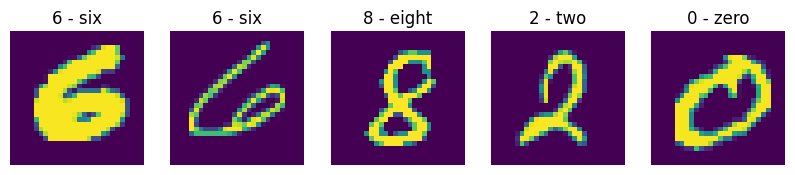

In [5]:
import matplotlib.pyplot as plt 
torch.manual_seed(42)
nrows = 1
ncols = 5
fig = plt.figure(figsize=(10,7))

for i in range(5):
    rand_idx = torch.randint(low=0, high=len(train_dataset), size=[1]).item()
    image, label = train_dataset[rand_idx]
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(image.squeeze())
    plt.axis(False)
    plt.title(class_names[label])
    


In [6]:
image.shape

torch.Size([1, 28, 28])

#### **7.** Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [7]:
# Turn the datasets into dataloaders 
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=32,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x71ac3c0daca0>,
 <torch.utils.data.dataloader.DataLoader at 0x71ac3c0dad00>)

#### **8.** Recreate model_2 used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset. 

In [8]:
from torch import nn

class NumberClassification(nn.Module):
    def __init__(self,
                 input_channels:int,
                 output_shape:int,
                 hidden_units:int,
                 stride: int = 1,
                 padding: int = 0,
                 kernel_size: tuple = (3,3),
                 maxpool_kernel_size: tuple = (2,2)) -> None:
        
        super().__init__()
    
        # FEATURE SELECTION
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel_size)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=stride,
                      padding=padding,
                      kernel_size=kernel_size),
            nn.MaxPool2d(kernel_size=maxpool_kernel_size)
        )

        # CLASSIFICATION 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 4 * 4,  
                      out_features=output_shape) 
        )
        
    
    def forward(self,
                x:torch.Tensor) -> torch.Tensor:
        
        if (False): # This is just for finding the output shape of the flatten layer 
            x = self.conv_block_1(x) 
            print(f"Shape after first conv block: {x.shape}")
            x = self.conv_block_2(x)
            print(f"Shape afeter second conv block: {x.shape}")
            x = self.classifier(x)
            print(f"Shape after classification: {x.shape}")
            return x 
        else: # This is the normal way of inference
            return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [9]:
# Make a prediction to find the outputshape of the flatten
tmp = NumberClassification(input_channels=1,
                           hidden_units=10,
                           output_shape=n_classes).to(device)
tmp(torch.randn(size=(1, 28, 28)).to(device).unsqueeze(dim=0))

tensor([[ 0.0229,  0.0016,  0.0167,  0.0581,  0.0744,  0.0169,  0.1171, -0.0010,
         -0.0415, -0.0071]], device='cuda:0', grad_fn=<AddmmBackward0>)

#### **9.** Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [10]:
from timeit import default_timer as timer 
from torchmetrics import Accuracy

model_cpu = NumberClassification(input_channels=1,
                                 output_shape=n_classes,
                                 hidden_units=10).to("cpu")
model_gpu = NumberClassification(input_channels=1,
                                 output_shape=n_classes,
                                 hidden_units=10).to("cuda")

In [11]:
# Loss & optim
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_cpu = torch.optim.SGD(params=model_cpu.parameters(),
                            lr=.1)
optimizer_gpu = torch.optim.SGD(params=model_gpu.parameters(),
                            lr=.1)
acc_fn_cpu=Accuracy(task="multiclass",
                num_classes=n_classes).to("cpu")
acc_fn_gpu=Accuracy(task="multiclass",
                num_classes=n_classes).to("cuda")
               

In [12]:
# Train and test steps definded
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               acc_fn,
               optimizer: torch.optim.Optimizer,
               dev:str):
    
    '''
    Performs the train step
    Model output must be logits
    
    Args:
        model: nn.Module
        dataloader: DataLoader
        loss_fn: nn.Module
        acc_fn: Accuracy
        optimizer: torch.optim.Optimizer
        device:str
    '''
    
    # Train mode
    model.train()
    
    # Cum-variables 
    train_loss, train_acc = 0.0, 0.0
    
    # Weights update per batch 
    for batch, (X, y) in enumerate(dataloader):
        
        # Progress tracking 
        step = len(dataloader) // 10
        if batch % step == 0:
            progress_completed: int = batch // step
            print_progress(progress_completed)
            
        X, y = X.to(dev), y.to(dev)
        
        # 1. Forward step
        pred_logits = model(X)
        
        # 2. Calculate the loss & accuracy 
        loss = loss_fn(pred_logits, y)
        train_loss += loss.item()
        train_acc += acc_fn(pred_logits.argmax(dim=1), y).item()
        
        # 3. Optimizer zero gradient 
        optimizer.zero_grad()
        
        # 4. Backpropagation
        loss.backward()
        
        # 5. Gradient descent step
        optimizer.step()
    
    # Average loss & accuracy
    train_loss /= len(dataloader)
    train_acc  /= len(dataloader)
    
    # Results tracking 
    print(f"\nTrain loss:     {train_loss:.4f}\nTrain accuracy: {train_acc:.2f}")



def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              dev:str):
    
    
    # Inference mode 
    with torch.inference_mode():
        model.eval()
        
        # Cum-variables 
        test_loss, test_acc = 0.0, 0.0

        # Iteration per batch 
        for batch, (X, y) in enumerate(dataloader):
            
             # Progress tracking 
            step = len(dataloader) // 10
            if batch % step == 0:
                progress_completed: int = batch // step
                print_progress(progress_completed)
                
            X, y = X.to(dev), y.to(dev)
            
            # 1. Forward pass
            pred_logits = model(X)
            
            # 2. Calculate loss & accuracy 
            loss_batch = loss_fn(pred_logits, y)
            test_loss += loss_batch.item()
            test_acc += acc_fn(pred_logits.argmax(dim=1), y).item()
            
        # Average loss & accuracy 
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        
        # Results tracking  
        print(f"\nTest loss:      {test_loss:.4f}\nTest accuracy:  {test_acc:.2f}")
    return 

In [13]:
# CPU version 
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cpu_start_time = timer()
epochs = 3
print("---------")
for e in range(epochs):
    print(f"Epoch: {e}")
    train_step(dataloader=train_dataloader,
               model=model_cpu,
               loss_fn=loss_fn,
               acc_fn=acc_fn_cpu,
               optimizer=optimizer_cpu,
               dev="cpu")
    test_step(dataloader=test_dataloader,
              model=model_cpu,
              loss_fn=loss_fn,
              acc_fn=acc_fn_cpu,
              dev="cpu")
    print("---------")
cpu_end_time = timer()
cpu_total_time = cpu_end_time - cpu_start_time

---------
Epoch: 0
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.2420
Train accuracy: 0.92
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.0699
Test accuracy:  0.98
---------
Epoch: 1
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.0716
Train accuracy: 0.98
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.0458
Test accuracy:  0.99
---------
Epoch: 2
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.0562
Train accuracy: 0.98
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.0514
Test accuracy:  0.98
---------


In [14]:
# GPU version 
torch.manual_seed(42)
torch.cuda.manual_seed(42)
gpu_start_time = timer()
epochs = 3
print("---------")
for e in range(epochs):
    print(f"Epoch: {e}")
    train_step(dataloader=train_dataloader,
               model=model_gpu,
               loss_fn=loss_fn,
               acc_fn=acc_fn_gpu,
               optimizer=optimizer_gpu,
               dev="cuda")
    test_step(dataloader=test_dataloader,
              model=model_gpu,
              loss_fn=loss_fn,
              acc_fn=acc_fn_gpu,
              dev="cuda")
    print("---------")
gpu_end_time = timer()
gpu_total_time = gpu_end_time - gpu_start_time

---------
Epoch: 0
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.2877
Train accuracy: 0.90
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.0756
Test accuracy:  0.98
---------
Epoch: 1
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.0777
Train accuracy: 0.98
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.0513
Test accuracy:  0.98
---------
Epoch: 2
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.0593
Train accuracy: 0.98
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.0496
Test accuracy:  0.98
---------


In [15]:
print(f"Training time for CPU: {cpu_total_time}\nTraining time for GPU: {gpu_total_time}")

Training time for CPU: 24.324517827000022
Training time for GPU: 19.593926807999992


#### **10.** Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label. 

In [16]:
import random
random.seed(42)
torch.manual_seed(42)

samples_list = []
labels_list = []
for img, label in random.sample(list(test_dataset), k=5):
    
    samples_list.append(img)
    labels_list.append(label)

len(samples_list), len(labels_list), samples_list[0].shape

(5, 5, torch.Size([1, 28, 28]))

In [17]:
import random
def make_predictions(model: nn.Module,
                     data: list,
                     dev: str) -> torch.Tensor:
    '''
    Make predictions with the given data and model
    Args:
        model: nn.Module
        data: list = list of tensors 
        dev: str = device
    '''
    
    probs_list = []
    
    # Inference mode 
    with torch.inference_mode():
        model_gpu.eval()
        
        for sample in data:
            # 1. Forward pass 
            logits = model(sample.to(dev).unsqueeze(dim=0))
            #print(logits.shape)
            
            # 2. Calculate probs
            probs_list.append(torch.softmax(logits.squeeze(), dim=0).cpu())
            
    return torch.stack(probs_list)

In [18]:
# Get class probabilities
probs = make_predictions(model=model_gpu,
                 data=samples_list,
                 dev="cuda")
print(f"Probs shape: {probs.shape}")

# Get most likely 
preds = torch.argmax(probs, dim=1)
print(f"Preds shape: {preds.shape}")

Probs shape: torch.Size([5, 10])
Preds shape: torch.Size([5])


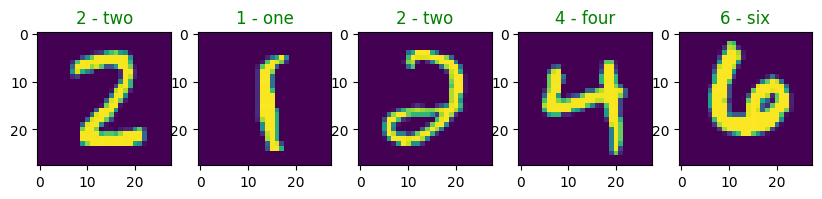

In [19]:
from extra_functions import plot_pred_images
plot_pred_images(preds=list(preds),
                 y=labels_list,
                 figsize=(10, 2),
                 nrows=1,
                 ncols=5,
                 images=samples_list,
                 class_names=class_names)

#### **11.** Plot a confusion matrix comparing your model's predictions to the truth labels.


In [20]:
from tqdm.auto import tqdm
torch.manual_seed(42)

y_preds = [] # List of predictions on the test data

with torch.inference_mode():
    model_gpu.eval()
    
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        # Forward pass
        logits = model_gpu(X)
        
        # Logits -> Label
        y_pred = logits.argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
        

Making predictions...: 100%|██████████| 313/313 [00:00<00:00, 533.32it/s]


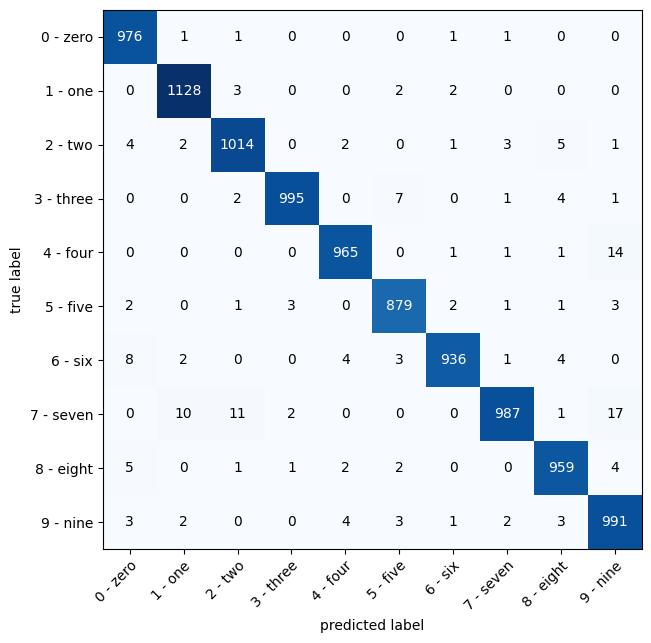

In [21]:
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix 

conf_mat = ConfusionMatrix(task="multiclass",
                           num_classes=n_classes)

conf_mat_tensor = conf_mat(preds=torch.cat(y_preds),
                           target=test_dataset.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)
plt.show()

## PONER MUCHAS PREDS CON TEST PARA ETSO MAQUINON 

#### **12.** Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [22]:
random_tensor = torch.randn(size=(1, 3, 64, 64)) # Basically a color image 

example_layer = nn.Conv2d(in_channels=3,
                          out_channels=3,
                          stride=2,
                          padding=1, 
                          kernel_size=(1,1))

output = example_layer(random_tensor)
print(f"Input shape: {random_tensor.shape}\nOutput shape: {output.shape}")


Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 33, 33])


Note: shape = (n_images, C, H, W)

When the kernel size increment it reduces the output shape. The max shape you can get with just changing the kernel size is with (1,1) when, basically, using a filter per pixel (which is not very usefull). With and stride 1, you lose unit size dim (per dimension, in this case, just in H & W) every extra unit you give to the kernel size, with a stride 2, you lose it every two extra units, if we continue like that, for a stride 10 you will lose a unit every 10 units of size.  

#### **13.** Use a model similar to the trained model_2 from this notebook to make predictions on the test torchvision.datasets.FashionMNIST dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualizing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

##### 13.1 Dataset 

In [23]:
# Download data 
train_dataset2 = torchvision.datasets.FashionMNIST(root="exercises_2.data",
                                                   train=True,
                                                   transform=torchvision.transforms.ToTensor(),
                                                   download=True)




test_dataset2 = torchvision.datasets.FashionMNIST(root="exercises_2.data",
                                                   train=False,
                                                   transform=torchvision.transforms.ToTensor(),
                                                   download=True)

In [24]:
train_dataset2[0][0].shape # Gray scale 

torch.Size([1, 28, 28])

In [25]:
class_names2 = train_dataset2.classes
class_names2[0]

'T-shirt/top'

##### 13.2 Model 

In [26]:
model_2 = NumberClassification(input_channels=1,
                               output_shape=len(class_names2),
                               hidden_units=10).to(device)
next(iter(model_2.parameters())).device

device(type='cuda', index=0)

##### 13.3 Dataloader 

In [27]:
train_dataloader2= DataLoader(dataset=train_dataset2,
                              shuffle=True,
                              batch_size=32)

test_dataloader2 = DataLoader(dataset=test_dataset2,
                              shuffle=False,
                              batch_size=32)

##### 13.5 Optimizer, loss and accuracy

In [28]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)
acc_fn = Accuracy(task="multiclass",
                  num_classes=len(class_names2)).to(device)

##### 13.5 Train loop 

In [29]:
epochs = 6
for e in range(epochs):
    train_step(model=model_2,
               dataloader=train_dataloader2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               acc_fn=acc_fn,
               dev=device)
    test_step(model=model_2,
               dataloader=test_dataloader2,
               loss_fn=loss_fn,
               acc_fn=acc_fn,
               dev=device)

Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.6224
Train accuracy: 0.78
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.4357
Test accuracy:  0.85
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.3947
Train accuracy: 0.86
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.3881
Test accuracy:  0.86
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.3549
Train accuracy: 0.87
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.3861
Test accuracy:  0.86
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.3354
Train accuracy: 0.88
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.3445
Test accuracy:  0.87
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.3206
Train accuracy: 0.88
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.3444
Test accuracy:  0.88
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Train loss:     0.3141
Train accuracy: 0.89
Train progress: ⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
Test loss:      0.3514
Test accuracy:  0.87


##### 13.6 Make and plot predictions where model was wrong 

In [44]:
# Make predictions 
preds = torch.Tensor([]).to(device)
with torch.inference_mode():
    model_2.eval()
    
    for X_batch, y_batch in test_dataloader2:# 32 Images & 32 labels per iteration
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        logits_batch = model_2(X_batch)
        #print(f"Shape of logits output: {logits_batch.shape}")
       
        # Inference
        y_pred_batch = logits_batch.argmax(dim=1)
        #print(f"Shape of prediction output: {y_pred_batch.shape}")
        
        preds = torch.cat((preds, y_pred_batch), dim=0)
        

preds.shape
        

torch.Size([10000])

In [48]:
# Getting the bad results 
preds = preds.type(dtype=torch.int64) # Dtype correction 
print(f"Shape of predictions: {preds.shape}\nShape of real labels tensor: {test_dataset2.targets.shape}")
print(f"Some predictions comparation: {preds[:10]} vs {test_dataset2.targets[:10]}")

Shape of predictions: torch.Size([10000])
Shape of real labels tensor: torch.Size([10000])
Some predictions comparation: tensor([9, 2, 1, 1, 6, 1, 2, 6, 5, 7], device='cuda:0') vs tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


In [57]:
# Searching for wrong predictions 
real_labels = test_dataset2.targets.to(device) 
wrong_predictions_idx_tensor = preds != real_labels
wrong_predictions_idx_tensor[:10]

tensor([False, False, False, False, False, False,  True, False, False, False],
       device='cuda:0')

In [64]:
print(f"Number of images: {real_labels.shape[0]}")
print(f"Number of wrong predictions: {real_labels[wrong_predictions_idx_tensor].shape[0]}")

Number of images: 10000
Number of wrong predictions: 1306


In [ ]:
# Getting all images in one tensor
all_images = torch.cat([images for images, _ in test_dataloader2], dim=0).to(device)
print(f"Wrong images shape: {all_images[wrong_predictions_idx_tensor].shape}")

Wrong images shape: torch.Size([1306, 1, 28, 28])


In [71]:
wrong_predictions_images = all_images[wrong_predictions_idx_tensor]
wrong_predictions_preds = preds[wrong_predictions_idx_tensor    ]
wrong_predictions_real_labels = real_labels[wrong_predictions_idx_tensor]
wrong_predictions_images.shape, wrong_predictions_preds.shape, wrong_predictions_real_labels.shape

(torch.Size([1306, 1, 28, 28]), torch.Size([1306]), torch.Size([1306]))

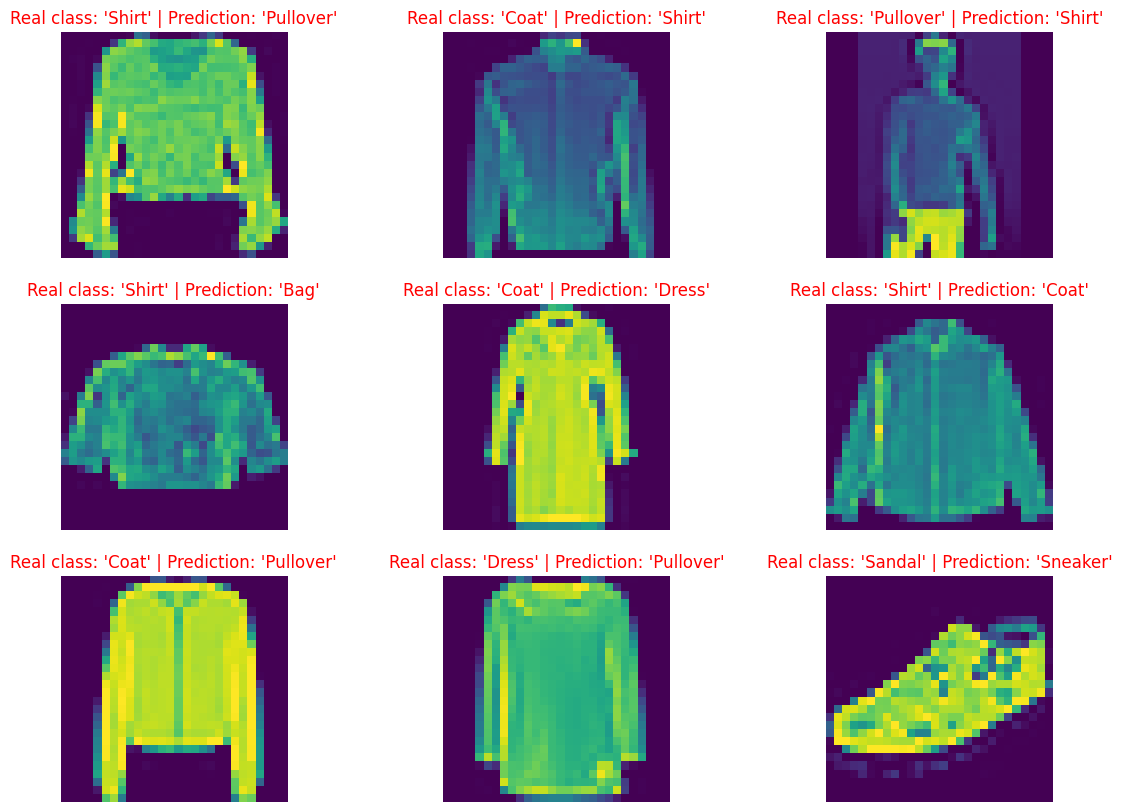

In [99]:
# Plot 9 images 
fig = plt.figure(figsize=(14, 10))
rows, cols = 3, 3

for i in range(1, rows*cols+1):
    rand_idx = int(torch.randint(0, len(wrong_predictions_images), size=[1]).item())
    img = wrong_predictions_images[rand_idx]
    pred = wrong_predictions_preds[rand_idx]
    y = wrong_predictions_real_labels[rand_idx]

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().cpu())
    plt.title(f"Real class: '{class_names2[y]}' | Prediction: '{class_names2[pred]}'", c="r")
    plt.axis(False)
    

After visualizing the wrong predictions we can say that it's both problem: model and data.
1. First, our model is not so complex, so the patterns that he learned are probably quite simple, so if the object has similiar size and proportions he may inference wrong.
2. Secondly, the data has a classes problem: there are some classes that are soo hard to distinguish (like shirt and t-shirt) that even a human would probably get it wrong.
3. Finally, the data has a poor quality: we have 28x28 pixeles images and it's on a gray scale, so we really have not much data to work. With more pixels and colors the model could learn better patterns for sure.